# 多 Agent 协作自动修复 K8s 故障

1. 管理员 Agent
2. 自动修复 Agent
3. 寻求人类帮助 Agent
4. 网络搜索 Agent
5. 执行代码 Agent

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

Could not fetch URL https://pypi.org/simple/langgraph/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/langgraph/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.org/simple/langchain/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/langchain/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))) - skipping
Could not fetch URL https://pypi.org/simple/langchain-openai/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/langchain-openai/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in vi

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
# 导入环境变量
import getpass
import os

# 定义函数，设置未定义的环境变量
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# 设置 OPENAI API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

import time
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# 初始化两个工具
tavily_tool = TavilySearchResults(max_results=5)
# 执行 Python 代码的工具，谨慎使用
python_repl_tool = PythonREPLTool()

In [3]:
# 定义消息 Agent 的节点
from langchain_core.messages import HumanMessage

# 定义一个消息代理节点，把结果封装成 HumanMessage 类型
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [4]:
# 定义 supervisor Agent 和调度逻辑
# 管理员 Agent，负责决定下一个由哪个 Agent 来执行任务

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal,Sequence
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

# 定义成员 Agent 和系统提示语，告诉 supervisor 要负责调度多个 Agent
members = ["Researcher","Coder","AutoFixK8s","HumanHelp","getK8sYAML"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members

# 定义 supervisor 的响应类，选择下一个执行的 Agent
class routeResponse(BaseModel):
    next: Literal[*options]

# 创建提示语模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# 定义 LLM 模型和 supervisor_agent 函数
llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [5]:
# 定义 K8s 自动修复工具
# 这里定义一个 K8s 自动修复工具，首先需要通过getK8sYaml agent拿到工作负载的YAML， 使用 OPENAI 模型生成 patch json
from langchain_core.tools import tool
from openai import OpenAI
from kubernetes import client, config, watch
import yaml

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()

@tool
def auto_fix_k8s(deployment_name, namespace, deployment_yaml, event: str):
    """自动修复 K8s 问题"""
    # # 先根据 deployment_name 去获取 Deployment YAML
    # deployment = k8s_apps_v1.read_namespaced_deployment(
    #     name=deployment_name, namespace=namespace
    # )
    # deployment_dict = deployment.to_dict()
    # # 移除不必要的字段
    # deployment_dict.pop("status", None)
    # if "metadata" in deployment_dict:
    #     deployment_dict["metadata"].pop("managed_fields", None)
    
    # # 请求 OpenAI 生成修复的 Patch JSON
    # deployment_yaml = yaml.dump(deployment_dict)

    print("Input Orignal yaml is:", deployment_yaml)

    if deployment_yaml == None:
        print(f"没有传入YAMLfile, {str(e)}")
        return f"没有传入YAMLfile, {str(e)}"

    OpenAIClient = OpenAI()
    response = OpenAIClient.chat.completions.create(
        model="gpt-4o",
        response_format={"type":"json_object"},
        messages=[
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
        K8s 抛出的错误信息是：{event}
        工作负载的 YAML 是：
        {deployment_yaml}
    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
    """,
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"修复失败：{str(e)}")
        return f"修复失败：{str(e)}"

    return f"工作自动修复成功！"

In [6]:
# 定义获取工作负载的YAML 的工具
# 在执行自动修复之前，获取工作负载的YAML，以便提供给k8s自动修复工具
from langchain_core.tools import tool


@tool
def getK8sYaml(deployment_name, namespace):
    ''' 获取原始的deployment YAML 文件 '''
       
    # 先根据 deployment_name 去获取 Deployment YAML
    deployment = k8s_apps_v1.read_namespaced_deployment(
        name=deployment_name, namespace=namespace
    )
    deployment_dict = deployment.to_dict()
    # 移除不必要的字段
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)
    
    # 请求 OpenAI 生成修复的 Patch JSON
    deployment_yaml = yaml.dump(deployment_dict)

    return deployment_yaml

In [7]:
# 定义人工帮助的 Tool
# 用于在无法自动修复的时候发送飞书消息通知

import requests
import json

@tool
def human_help(event_message: str):
    """无法修复问题时寻求人工帮助"""
    url = "https://open.feishu.cn/open-apis/bot/v2/hook/d5e267dc-a92f-43d3-bc45-106b5e718c49"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message}}
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"

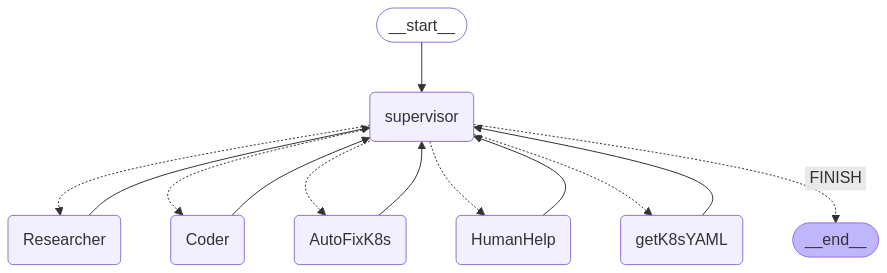

In [8]:
# 定义工作流和 Graph（有向有环图）
# 创建工作流，并且给节点添加 route 路由逻辑

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# 创建  GetK8sYAML Agent
getK8sYAML_agent = create_react_agent(llm, tools=[getK8sYaml])
getK8sYAML_node =  functools.partial(agent_node, agent=getK8sYAML_agent, name="getK8sYAML")

# auto fix agent
auto_fix_agent = create_react_agent(llm, tools=[auto_fix_k8s])
auto_fix_node = functools.partial(agent_node, agent=auto_fix_agent, name="AutoFixK8s")

# human help agent
human_help_agent = create_react_agent(llm, tools=[human_help])
human_help_node = functools.partial(agent_node, agent=human_help_agent, name="HumanHelp")

# 创建 Graph 并且添加节点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", research_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("AutoFixK8s", auto_fix_node)
workflow.add_node("HumanHelp", human_help_node)
workflow.add_node("getK8sYAML", getK8sYAML_node)

# 定义路由逻辑
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass






In [9]:
# # 硬编码 Event 测试效果
# for s in graph.stream(
#     {
#         "messages": [
#             #HumanMessage(content="deployment: nginx, namespace: default, event: Back-off pulling image 'nginx:latess'")
#             HumanMessage(content="deployment: 'unkonw', namespace: 'default', event:  0/3 nodes are available: 1 Insufficient cpu, 2 Insufficient memory.")
#         ]
#     }
# ):
#     if "__end__" not in s:
#         print(s)
#         print("----")

In [ ]:
# 捕获和处理 K8s 事件
# 监听 K8s 的产生，并且调用 Supervisor 处理事件

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()
core_v1 = client.CoreV1Api()

w = watch.Watch()

def run_stream(message: str):
    for s in graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        }
    ):
        if "__end__" not in s:
            print(s)
            print("----")

try:
    namespace = "default"
    for event in w.stream(
        core_v1.list_namespaced_event, namespace=namespace, _request_timeout=None
    ):
        event_type = event["type"]
        event_object = event["object"]

        # 检查事件类型
        if event_object.type == "Warning":
            involved_object = event_object.involved_object
            pod_name = involved_object.name
            reason = event_object.reason
            message = event_object.message

            print(f"Warning Event: {event_type} {pod_name} - {reason} - {message}")

            # 处理异常：Pod 可能不存在
            try:
                pod = core_v1.read_namespaced_pod(name=pod_name, namespace=namespace)
                deployment_name = pod.metadata.labels.get("app","unknown")
            except client.exceptions.ApiException as e:
                print(f"Error reading Pod {pod_name}: {e}")
                continue
            
            # 传递 Warning 事件到 run_stream()
            try:
                run_stream(f"deployment: {deployment_name}, namespace: {namespace}, event: {reason} - {message}")
                time.sleep(10)
            except Exception as e:
                print(e)
                continue
        else:
            print(f"Ignore non-warning event: {event_object.type} {event_object.reason} - {event_object.message}")
    
finally:
    w.stop()

Ignore non-warning event: Normal Killing - Stopping container nginx
Ignore non-warning event: Normal ScalingReplicaSet - Scaled up replica set nginx-67f4555c6c to 1
Ignore non-warning event: Normal SuccessfulCreate - Created pod: nginx-67f4555c6c-6flx4
Ignore non-warning event: Normal Scheduled - Successfully assigned default/nginx-67f4555c6c-6flx4 to docker-desktop
Ignore non-warning event: Normal Pulling - Pulling image "nginx:latsss"


DEBUG:kubernetes.client.rest:response body: {"kind":"Pod","apiVersion":"v1","metadata":{"name":"nginx-67f4555c6c-6flx4","generateName":"nginx-67f4555c6c-","namespace":"default","uid":"a932c3f7-ffe0-430f-808d-00fb50700c2b","resourceVersion":"10078","creationTimestamp":"2025-03-08T15:49:25Z","labels":{"app":"nginx","pod-template-hash":"67f4555c6c"},"ownerReferences":[{"apiVersion":"apps/v1","kind":"ReplicaSet","name":"nginx-67f4555c6c","uid":"4aa7d9ac-4744-41bb-a4b8-1c4f51f9cac8","controller":true,"blockOwnerDeletion":true}],"managedFields":[{"manager":"kube-controller-manager","operation":"Update","apiVersion":"v1","time":"2025-03-08T15:49:25Z","fieldsType":"FieldsV1","fieldsV1":{"f:metadata":{"f:generateName":{},"f:labels":{".":{},"f:app":{},"f:pod-template-hash":{}},"f:ownerReferences":{".":{},"k:{\"uid\":\"4aa7d9ac-4744-41bb-a4b8-1c4f51f9cac8\"}":{}}},"f:spec":{"f:containers":{"k:{\"name\":\"nginx\"}":{".":{},"f:image":{},"f:imagePullPolicy":{},"f:name":{},"f:resources":{},"f:termina

Warning Event: ADDED nginx-67f4555c6c-6flx4 - Failed - Failed to pull image "nginx:latsss": Error response from daemon: manifest for nginx:latsss not found: manifest unknown: manifest unknown


DEBUG:httpcore.proxy:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x00000249DE97B530>
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:12 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'801'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37ca1eb68e9e4-LAX'), (b'Openai-Organization', b'user-gjcyznu94m2aqhfjfcyizq9n'), (b'Openai-Processing-Ms', b'625'), (b'Openai-Version',

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:21 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37ca93ed2e9e4-LAX'), (b'Openai-Organization', b'user-g2wqe6dhx3vba59el5watu4x'), (b'Openai-Processing-Ms', b'8628'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=ko5vwcNSZT_ldODkK_H9hce3tu1m4KFGS_EMNnJJXjQ-1741449021-1.0.1.1-sdGcf.Vjmyl1UioaN.5avCoK4.q4BobZVkcyMFlrNk8_qjMdmU9P_snyTfku5KG7RlV4wfBYTDdkJL0mL2Xt_MpkG__gFAzi8Y3LAVFALYQ; path=/; expires=Sat, 08-Mar-25 16:20:21 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

{'Researcher': {'messages': [HumanMessage(content='The error message indicates that the deployment is attempting to pull an image with the tag "latsss" for nginx, but this tag doesn\'t exist in the image registry. Here\'s how you can troubleshoot and resolve this issue:\n\n1. **Check the Tag Name**: Review the tag used for the image. It\'s possible that there\'s a typo. The most common tags for nginx are `latest`, `stable`, `mainline`, etc. Ensure the tag is correct.\n\n2. **Update Deployment Configuration**: If you confirm there\'s a typo, update your Kubernetes deployment configuration to use a valid image tag. Here\'s an example of how you can specify a typical nginx image:\n\n   ```yaml\n   apiVersion: apps/v1\n   kind: Deployment\n   metadata:\n     name: nginx-deployment\n     namespace: default\n   spec:\n     replicas: 3\n     selector:\n       matchLabels:\n         app: nginx\n     template:\n       metadata:\n         labels:\n           app: nginx\n       spec:\n         co

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:22 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'395'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'86866d60-b1f7-4066-bfd9-cfc2ed2b35a8'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'283'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'306'), (b'X-Ms-Client-Request-Id', b'86866d60-b1f7-4066-bfd9-cfc2ed2b35a8'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'150'), (b'X-Ratelimit-Limit-Tokens', b'150000'), (b'X-Ratelimit-Remaining-Requests', b'149'), (b'X-Ratelimit-Remaining-Tokens', b'148736'), (b'X-Request-Id', b'0066ec3a-f29d-4ba6-8532-bc2016717dbe'), (b'X-Shel

{'supervisor': {'next': 'getK8sYAML'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:24 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37ce90a8fe9e4-LAX'), (b'Openai-Organization', b'user-8l0uwiqo2smdej1xfl1czazk'), (b'Openai-Processing-Ms', b'893'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=Pr50dccrI4mUyEjkxJ43Ueeel24ajW8lBncDe_coKTE-1741449023-1.0.1.1-mftJj_HdcyYvP13XEfvVI8OEc5X43suXU2giSc3HSB6HeR445mKqJkbJJjgxs1UL7fU9RAxzZlYsAyzUqU7p4unk31JF059CIMgVYHCX7Ns; path=/; expires=Sat, 08-Mar-25 16:20:23 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Op

{'getK8sYAML': {'messages': [HumanMessage(content="The current Kubernetes deployment configuration for `nginx` in the `default` namespace indeed specifies an image tag `nginx:latsss`, which is incorrect and causing the failure to pull the image. Here's the relevant portion of the configuration:\n\n```yaml\ncontainers:\n- image: nginx:latsss\n  name: nginx\n```\n\nTo fix this issue, you need to update the deployment to use a correct image tag. Here's how you can update it to use a valid tag like `nginx:latest`:\n\n```yaml\napiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx\n  namespace: default\nspec:\n  replicas: 1\n  selector:\n    matchLabels:\n      app: nginx\n  strategy:\n    type: RollingUpdate\n    rollingUpdate:\n      maxSurge: 25%\n      maxUnavailable: 25%\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: nginx:latest # Corrected here\n        imagePullPolicy: IfNotPresent\n```\n\n**

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:32 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'395'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'03dd399f-f0c9-4bac-8653-e701343192c6'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'250'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'252'), (b'X-Ms-Client-Request-Id', b'03dd399f-f0c9-4bac-8653-e701343192c6'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'449'), (b'X-Ratelimit-Remaining-Tokens', b'448393'), (b'X-Request-Id', b'617f0b79-73fe-4d4d-bbc9-a2847660e33f'), (b'X-S

{'supervisor': {'next': 'AutoFixK8s'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:37 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37d28d885e9e4-LAX'), (b'Openai-Organization', b'user-ex47jchn39nstueigequfwgw'), (b'Openai-Processing-Ms', b'4049'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=QGV0MnjuK9En2rBqxkIBa_Zzl83ms8prPig2xE4Lx8M-1741449037-1.0.1.1-KBoethbgyvXmIf7.8KqHNIWLUP2io4._t6v.nkljJeOUh2YA4zbr8LuIMcZEbKY6Yc0QVGSwE_1mkblILQaIXM2OboWjAy29b7Bng09axqc; path=/; expires=Sat, 08-Mar-25 16:20:37 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

Input Orignal yaml is: apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx
  namespace: default
spec:
  replicas: 1
  selector:
    matchLabels:
      app: nginx
  strategy:
    type: RollingUpdate
    rollingUpdate:
      maxSurge: 25%
      maxUnavailable: 25%
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:latest # Corrected here
        imagePullPolicy: IfNotPresent


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': '你是一个助理用来输出 JSON'}, {'role': 'user', 'content': '你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。\n        K8s 抛出的错误信息是：Failed - Failed to pull image "nginx:latsss": Error response from daemon: manifest for nginx:latsss not found: manifest unknown: manifest unknown\n        工作负载的 YAML 是：\n        apiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx\n  namespace: default\nspec:\n  replicas: 1\n  selector:\n    matchLabels:\n      app: nginx\n  strategy:\n    type: RollingUpdate\n    rollingUpdate:\n      maxSurge: 25%\n      maxUnavailable: 25%\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: nginx:latest # Corrected here\n        imagePullPolicy: IfNotPresent\n    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其

{
  "spec": {
    "template": {
      "spec": {
        "containers": [
          {
            "name": "nginx",
            "image": "nginx:latest"
          }
        ]
      }
    }
  }
}


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:42 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Apim-Request-Id', b'22596632-b656-4622-99e1-8b0eae9ad8d8'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Cmp-Upstream-Response-Duration', b'977'), (b'Ms-Azureml-Model-Time', b'1022'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus2-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'1024'), (b'X-Ms-Client-Request-Id', b'22596632-b656-4622-99e1-8b0eae9ad8d8'), (b'X-Ms-Rai-Invoked', b'true'), (b'X-Ms-Region', b'East US 2'), (b'X-Ratelimit-Limit-Requests', b'300'), (b'X-Ratelimit-Limit-Tokens', b'300000'), (b'X-Ratelimit-Remaining-Requests', b'299'), (b'X-Ratelimit-Remaining-Tok

{'AutoFixK8s': {'messages': [HumanMessage(content='The issue with the deployment for `nginx` in the `default` namespace has been successfully resolved. The image tag was corrected from `nginx:latsss` to `nginx:latest`, and the deployment should now be able to pull the image without any issues. You can verify the status of the pods with:\n\n```bash\nkubectl get pods -n default\n``` \n\nIf you need further assistance, feel free to ask!', additional_kwargs={}, response_metadata={}, name='AutoFixK8s')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:43 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'986'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'7df3be22-1bec-4c0e-b5c5-ee2dd1e40705'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Cmp-Upstream-Response-Duration', b'587'), (b'Ms-Azureml-Model-Time', b'628'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus2-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'630'), (b'X-Ms-Client-Request-Id', b'7df3be22-1bec-4c0e-b5c5-ee2dd1e40705'), (b'X-Ms-Rai-Invoked', b'true'), (b'X-Ms-Region', b'East US 2'), (b'X-Ratelimit-Limit-Requests', b'300'), (b'X-Ratelimit-Limit-Tokens', b'300000'), (b'X-Ratelimit-Remaining-Requests', b'299'), (b'X-Ratelimit-Remaining-Tokens', b'298297'), (b'X-Request-Id', b'49

{'supervisor': {'next': 'FINISH'}}
----


DEBUG:kubernetes.client.rest:response body: {"kind":"Pod","apiVersion":"v1","metadata":{"name":"nginx-67f4555c6c-6flx4","generateName":"nginx-67f4555c6c-","namespace":"default","uid":"a932c3f7-ffe0-430f-808d-00fb50700c2b","resourceVersion":"10210","creationTimestamp":"2025-03-08T15:49:25Z","deletionTimestamp":"2025-03-08T15:51:11Z","deletionGracePeriodSeconds":30,"labels":{"app":"nginx","pod-template-hash":"67f4555c6c"},"ownerReferences":[{"apiVersion":"apps/v1","kind":"ReplicaSet","name":"nginx-67f4555c6c","uid":"4aa7d9ac-4744-41bb-a4b8-1c4f51f9cac8","controller":true,"blockOwnerDeletion":true}],"managedFields":[{"manager":"kube-controller-manager","operation":"Update","apiVersion":"v1","time":"2025-03-08T15:49:25Z","fieldsType":"FieldsV1","fieldsV1":{"f:metadata":{"f:generateName":{},"f:labels":{".":{},"f:app":{},"f:pod-template-hash":{}},"f:ownerReferences":{".":{},"k:{\"uid\":\"4aa7d9ac-4744-41bb-a4b8-1c4f51f9cac8\"}":{}}},"f:spec":{"f:containers":{"k:{\"name\":\"nginx\"}":{".":{},

Warning Event: ADDED nginx-67f4555c6c-6flx4 - Failed - Error: ErrImagePull


DEBUG:httpcore.proxy:start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x00000249DE9F4710>
DEBUG:httpcore.http11:send_request_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_headers.complete
DEBUG:httpcore.http11:send_request_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:send_request_body.complete
DEBUG:httpcore.http11:receive_response_headers.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:55 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'802'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37db0d9a3e9e4-LAX'), (b'Openai-Organization', b'user-3v6cagjofw3ahhm5w4sjaea2'), (b'Openai-Processing-Ms', b'497'), (b'Openai-Version',

{'supervisor': {'next': 'AutoFixK8s'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:56 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'945'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'bf1c7df9-a7fa-4dd2-a339-e6afc43184a8'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Cmp-Upstream-Response-Duration', b'446'), (b'Ms-Azureml-Model-Time', b'476'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus2-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'478'), (b'X-Ms-Client-Request-Id', b'bf1c7df9-a7fa-4dd2-a339-e6afc43184a8'), (b'X-Ms-Rai-Invoked', b'true'), (b'X-Ms-Region', b'East US 2'), (b'X-Ratelimit-Limit-Requests', b'300'), (b'X-Ratelimit-Limit-Tokens', b'300000'), (b'X-Ratelimit-Remaining-Requests', b'299'), (b'X-Ratelimit-Remaining-Tokens', b'297638'), (b'X-Request-Id', b'9e

Input Orignal yaml is: None


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:50:58 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'754'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'b305623f-0587-4a31-9854-f365a2908399'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'974'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'977'), (b'X-Ms-Client-Request-Id', b'b305623f-0587-4a31-9854-f365a2908399'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'448'), (b'X-Ratelimit-Remaining-Tokens', b'446496'), (b'X-Request-Id', b'27bf4544-b0b3-4ba5-8cb5-8c36c90f91bf'), (b'X-S

Input Orignal yaml is: None


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:00 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'631'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'538feeee-21f2-4e8a-bafe-e7c5a9192564'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'709'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'711'), (b'X-Ms-Client-Request-Id', b'538feeee-21f2-4e8a-bafe-e7c5a9192564'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'447'), (b'X-Ratelimit-Remaining-Tokens', b'445743'), (b'X-Request-Id', b'79b310dc-8a6d-4392-a660-fae0b57038cf'), (b'X-S

{'AutoFixK8s': {'messages': [HumanMessage(content="I encountered an issue while trying to address the problem with your deployment. Could you clarify if there’s specific YAML or configuration details you'd like addressed alongside the `ErrImagePull` error for the `nginx` deployment in the `default` namespace?", additional_kwargs={}, response_metadata={}, name='AutoFixK8s')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:01 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'802'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37dd4e9b6e9e4-LAX'), (b'Openai-Organization', b'user-pbicyg1pafuhffnaclob075k'), (b'Openai-Processing-Ms', b'392'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=3mvob9JM.ZMccqnFv5.DJ3eECy7eXqE9w5RG5rdMyL0-1741449061-1.0.1.1-qcIBk8Du75Y5EXhHccigmUudhyhzRP3O2sJvhq6hAGX7dK4cdZKakwbkXLP9c.O_hen4Jhivv4nuWvLOujTjBGjQPWmPmMzxp6ebn60rECQ; path=/; expires=Sat, 08-Mar-25 16:21:01 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Oneapi-Reque

{'supervisor': {'next': 'getK8sYAML'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:02 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'558'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'51aaf9c9-8f15-4bdd-aa11-2d572dfb7c31'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'586'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'589'), (b'X-Ms-Client-Request-Id', b'51aaf9c9-8f15-4bdd-aa11-2d572dfb7c31'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'446'), (b'X-Ratelimit-Remaining-Tokens', b'445019'), (b'X-Request-Id', b'f2511177-4bdd-4c70-ac41-99993db50977'), (b'X-S

{'getK8sYAML': {'messages': [HumanMessage(content="The deployment configuration for `nginx` in the `default` namespace is using the image `nginx:latest` with an `image_pull_policy` of `IfNotPresent`. Here's a summary of the YAML configuration:\n\n```yaml\napiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx\n  namespace: default\nspec:\n  replicas: 1\n  selector:\n    matchLabels:\n      app: nginx\n  strategy:\n    type: RollingUpdate\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: nginx:latest\n        imagePullPolicy: IfNotPresent\n```\n\nTo address the `ErrImagePull` error:\n\n1. **Check Image Availability:** Ensure that the `nginx:latest` image is available. If there's an issue with the tag, try specifying a different, stable tag.\n   \n2. **Image Pull Policy:** The `IfNotPresent` policy might prevent pulling the updated image when `latest` tag is used if the image already exists on the no

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:07 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'394'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'0c367f46-8b33-4269-a44a-8d08b1cbcc67'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'390'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'393'), (b'X-Ms-Client-Request-Id', b'0c367f46-8b33-4269-a44a-8d08b1cbcc67'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'446'), (b'X-Ratelimit-Remaining-Tokens', b'443805'), (b'X-Request-Id', b'7fbce2b7-1c47-4e16-8aa3-8c4365706334'), (b'X-S

{'supervisor': {'next': 'AutoFixK8s'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:12 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d37e053bdce9e4-LAX'), (b'Openai-Organization', b'user-lo2zh3c8d7wfakfvambkinal'), (b'Openai-Processing-Ms', b'4162'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=scOdsPTp0yE95tQHXBd1bxDh4arj0xd7b4pns_fn8IM-1741449072-1.0.1.1-Tysh1Lq60jRIjJYxTih_tIR0wWXXCAE5kl8lbBcpC69kYicpbxdny0DGdJn4Af1NykTFl.xI7x018hubArt24rPz7x0YxxTRxamOB7d3nbc; path=/; expires=Sat, 08-Mar-25 16:21:12 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

Input Orignal yaml is: apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx
  namespace: default
spec:
  replicas: 1
  selector:
    matchLabels:
      app: nginx
  strategy:
    type: RollingUpdate
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:latest
        imagePullPolicy: IfNotPresent


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': '你是一个助理用来输出 JSON'}, {'role': 'user', 'content': '你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。\n        K8s 抛出的错误信息是：Failed - Error: ErrImagePull\n        工作负载的 YAML 是：\n        apiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx\n  namespace: default\nspec:\n  replicas: 1\n  selector:\n    matchLabels:\n      app: nginx\n  strategy:\n    type: RollingUpdate\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: nginx:latest\n        imagePullPolicy: IfNotPresent\n    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内\n    '}], 'model': 'gpt-4o', 'response_format': {'type': 'json_object'}}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://vip.apiyi.com/v1/chat/completions

{
  "spec": {
    "template": {
      "spec": {
        "containers": [
          {
            "name": "nginx",
            "imagePullPolicy": "Always"
          }
        ]
      }
    }
  }
}


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:19 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'551'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'5207fcdb-8024-4aca-ac62-d531017e5458'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'3086'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'3090'), (b'X-Ms-Client-Request-Id', b'5207fcdb-8024-4aca-ac62-d531017e5458'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'447'), (b'X-Ratelimit-Remaining-Tokens', b'441913'), (b'X-Request-Id', b'c841b5c7-b13c-4e20-bcc7-35993476f977'), (b'X

{'AutoFixK8s': {'messages': [HumanMessage(content='The issue with your `nginx` deployment in the `default` namespace has been successfully resolved! \n\nIf the problem persists or you need further assistance, feel free to reach out.', additional_kwargs={}, response_metadata={}, name='AutoFixK8s')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 15:51:21 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'390'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'2f1b2b23-9db1-4308-99aa-95a985a077b5'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'272'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'275'), (b'X-Ms-Client-Request-Id', b'2f1b2b23-9db1-4308-99aa-95a985a077b5'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'447'), (b'X-Ratelimit-Remaining-Tokens', b'440654'), (b'X-Request-Id', b'40f058a2-7c2e-4c27-b850-bf345f2e2e67'), (b'X-S

{'supervisor': {'next': 'FINISH'}}
----


DEBUG:kubernetes.client.rest:response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"pods \"nginx-67f4555c6c-6flx4\" not found","reason":"NotFound","details":{"name":"nginx-67f4555c6c-6flx4","kind":"pods"},"code":404}

DEBUG:kubernetes.client.rest:response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"pods \"nginx-67f4555c6c-6flx4\" not found","reason":"NotFound","details":{"name":"nginx-67f4555c6c-6flx4","kind":"pods"},"code":404}

DEBUG:kubernetes.client.rest:response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"pods \"nginx-67f4555c6c-6flx4\" not found","reason":"NotFound","details":{"name":"nginx-67f4555c6c-6flx4","kind":"pods"},"code":404}



Ignore non-warning event: Normal BackOff - Back-off pulling image "nginx:latsss"
Warning Event: ADDED nginx-67f4555c6c-6flx4 - Failed - Error: ImagePullBackOff
Error reading Pod nginx-67f4555c6c-6flx4: (404)
Reason: Not Found
HTTP response headers: HTTPHeaderDict({'Audit-Id': 'fedd975b-f3ed-4e2d-b62a-707ad501e1a2', 'Cache-Control': 'no-cache, private', 'Content-Type': 'application/json', 'X-Kubernetes-Pf-Flowschema-Uid': '04121893-9da6-4458-8812-cdc8ad56f858', 'X-Kubernetes-Pf-Prioritylevel-Uid': 'e1e847e2-5584-4fcb-9a3e-49741ac07e37', 'Date': 'Sat, 08 Mar 2025 15:51:31 GMT', 'Content-Length': '212'})
HTTP response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"pods \"nginx-67f4555c6c-6flx4\" not found","reason":"NotFound","details":{"name":"nginx-67f4555c6c-6flx4","kind":"pods"},"code":404}


Ignore non-warning event: Normal Pulling - Pulling image "nginx:latsss"
Ignore non-warning event: Normal ScalingReplicaSet - Scaled up replica set nginx-b85b